# Recreate Results from Paper

The purpose of this notebook is to recreate the results from *A Recommender System for Equitable Public Art Curation and Installation*.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy.ma as ma
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.manifold import SpectralEmbedding

import os
ROOT = os.popen("git rev-parse --show-toplevel").read().split("\n")[0]

import sys
sys.path.append(ROOT)

import src as sc

#######################################
# Comment this block out to show logging messages
import logging
logger = logging.getLogger()
assert len(logger.handlers) == 1
handler = logger.handlers[0]
handler.setLevel(logging.CRITICAL)
#######################################

COLOR_MAP = {"light_orange":"#E69F00",
             "light_blue":"#56B4E9",
             "teal":"#009E73",
             "yellow":"#F0E442",
             "dark_blue":"#0072B2",
             "dark_orange":"#D55E00",
             "pink":"#CC79A7",
             "purple":"#9370DB",
             "black":"#000000",
             "silver":"#DCDCDC"}

cmap = {"Man":COLOR_MAP["yellow"],
    "100000000000":COLOR_MAP["pink"],
    "1000000000000000":COLOR_MAP["purple"]
}

cmap_lam = {
    "1":COLOR_MAP["light_orange"],
    "10":COLOR_MAP["teal"],
    "100":COLOR_MAP["yellow"],
    "1000":COLOR_MAP["pink"],
    "10000":COLOR_MAP["purple"]
}

cmap_tau = {
    "0":COLOR_MAP["teal"],
    "1":COLOR_MAP["light_orange"],
    "100":COLOR_MAP["yellow"],
    "200":COLOR_MAP["dark_orange"],
    "500":COLOR_MAP["dark_blue"],
    "800":COLOR_MAP["silver"],
    "1000":COLOR_MAP["pink"]
}

cmap_beta = {
    "0.01":COLOR_MAP["light_orange"],
    str(10**2):COLOR_MAP["teal"],
    str(10**8):COLOR_MAP["yellow"],
    str(10**11):COLOR_MAP["dark_orange"],
    str(10**15):COLOR_MAP["dark_blue"],
}


# Load Data

In [2]:
# Load data
hall_df, student_df, art_df = sc.load_data()

# Get art_capacity_df
art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,categories = ["gender","race"])
art_capacity_df

# Get building_capacity_df.
building_capacity_df = sc.get_building_capacity_df()
building_capacity_df

# Fill buildings
sc.fill_buildings(student_df = student_df, hall_df = hall_df)

art_capacity_df

,string,capacity
0,"Woman, White",51
1,"Woman, Asian",2
2,"Woman, Hispanics of any race",0
3,"Woman, Black or African American",0
4,"Woman, Two or more races",0
5,"Woman, American Indian or Alaska Native",0
6,"Woman, Nat. Hawaiian or Other Pac Island",0
7,"Man, White",100
8,"Man, Asian",3
9,"Man, Hispanics of any race",18


# Initialize Parameters

#### Calibrate lambda and tau factors

In [4]:
# Compute normalizing constants for lambda and tau
norm_lam_factor, norm_tau_factor = sc.get_normalizing_constants(
                                                hall_df = hall_df,
                                                student_df = student_df,
                                                art_df = art_df
                                                                )

# Spectral Embeddings

### Run simulations for lambda = 1000

In [5]:
scaled_beta = [10**-2, 10**2, 10**8, 10**11,10**15]
scaled_lam = 10000
scaled_tau = [0, 100, 200, 500, 800, 1000]

In [6]:
cost_dict = {}
assignment_dict = {}
opt_dict = {}

In [10]:
for i in range(1):
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    for beta in scaled_beta:
        #Compute cost_df for fixed beta
        cost_df = sc.compute_cost_matrix(hall_df,
                                         student_df = student_df,
                                         art_df = art_df,
                                         categories = ["gender","race"],
                                         alpha = -1,
                                         beta = beta)

        cost_df.to_csv(f"spectral_sim_data_paper/cost_df_{beta}_{i}")
        
        lam = scaled_lam
        for tau in scaled_tau:
            # Compute optimal assignment for fixed tau.
            assignment_df = sc.learn_optimal_assignment(
                                 hall_df, 
                                 art_df,
                                 cost_df,  
                                 lam = norm_lam_factor*lam, 
                                 tau=norm_tau_factor*tau, 
                                 init=4,
                                 iterations = 1000
                                    ) 


            assignment_df.to_csv(f"spectral_sim_data_paper/assignment_df_{beta}_{lam}_{tau}_{i}")

In [11]:
lam = scaled_lam

values = []
beta_colors = []
tau_colors = []

# Concatenate data
for i in range(1):
    for beta in scaled_beta:
        for tau in scaled_tau:
            assignment_df = pd.read_csv(f"spectral_sim_data_paper/assignment_df_{beta}_{lam}_{tau}_{i}", index_col = 0)
            values.append(assignment_df.values.reshape(1,-1))
            tau_colors.append(cmap_tau[str(tau)])
            beta_colors.append(cmap_beta[str(beta)])
            
data = np.concatenate(values, axis = 0)

In [12]:
# Compute adjacency
X = np.empty((data.shape[0], data.shape[0]))
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        X[i,j] = np.abs(data[i,:] - data[j,:]).sum()
        
X = np.where(X == 0,1,X)
XX = (1/X) - np.eye(X.shape[0])

In [13]:
# Compute embedding
embedding = SpectralEmbedding(n_components=2, affinity = "precomputed", random_state = 42)
X_transformed = embedding.fit_transform(XX)

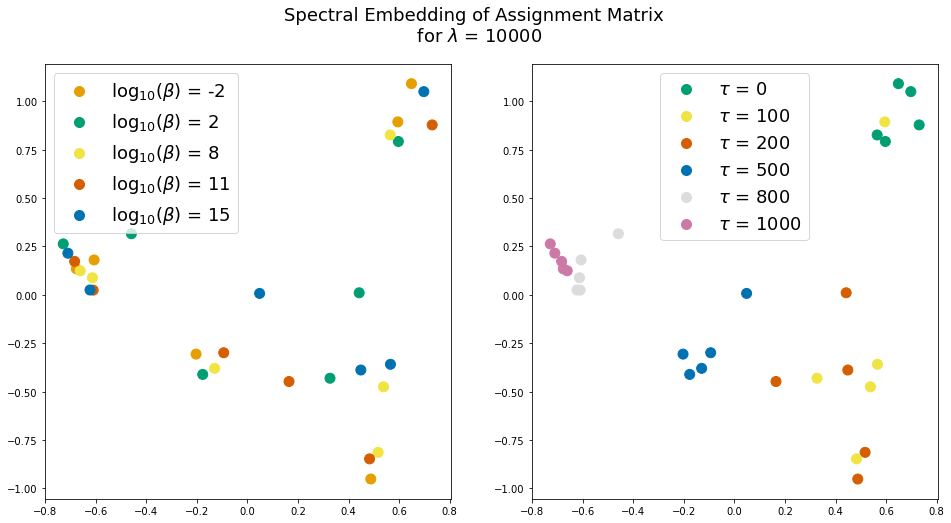

In [14]:
# Visualize emebdding
fig, ax = plt.subplots(1,2, figsize = (16,8))


ax[0].scatter(X_transformed[:,0], X_transformed[:,1], 
           c = beta_colors, 
           s = 100)
for t in cmap_beta.keys():
    ax[0].scatter([],[], color = cmap_beta[t],  label = "$\log_{10}$("+r"$\beta$"+") = {}".format(
        int(np.log10(float(t)))), s = 100)
ax[0].legend(fontsize = 18)

ax[1].scatter(X_transformed[:,0], X_transformed[:,1], 
           c = tau_colors, 
           s = 100)
for t in cmap_tau.keys():
    if t != "1":
        ax[1].scatter([],[], color = cmap_tau[t], label = r"$\tau$ = {}".format(t), s = 100)
ax[1].legend(fontsize = 18)

plt.suptitle("Spectral Embedding of Assignment Matrix \n for "+r"$\lambda$ = 10000", fontsize = 18)
plt.show()



### Run Similations for lambda = 100, tau = 1

In [15]:
scaled_beta = [10**-2, 10**2, 10**8, 10**11,10**15]
scaled_lam = .1
scaled_tau = .1

In [16]:
cost_dict = {}
assignment_dict = {}
opt_dict = {}

In [21]:
lam = scaled_lam
tau = scaled_tau

for i in range(1):
    print(i)
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    for beta in scaled_beta:
        #Compute cost_df for fixed beta
        cost_df = sc.compute_cost_matrix(hall_df,
                                         student_df = student_df,
                                         art_df = art_df,
                                         categories = ["gender","race"],
                                         alpha = -1,
                                         beta = beta)

        cost_df.to_csv(f"spectral_sim_data_paper/cost_df_{beta}_{i}")
        
        
        # Compute optimal assignment for fixed tau.
        assignment_df = sc.learn_optimal_assignment(
                                    hall_df, 
                                    art_df,
                                    cost_df,  
                                    lam = norm_lam_factor*lam, 
                                    tau=norm_tau_factor*tau, 
                                    init=4,
                                    iterations = 1000) 


        assignment_df.to_csv(f"spectral_sim_data_paper/assignment_df_{beta}_{lam}_{tau}_{i}")

0


In [22]:
lam = scaled_lam
tau = scaled_tau
values = []
beta_colors = []
tau_colors = []

# Concatenace data
for i in range(1):
    for beta in scaled_beta:
        assignment_df = pd.read_csv(f"spectral_sim_data_paper/assignment_df_{beta}_{lam}_{tau}_{i}", index_col = 0)
        values.append(assignment_df.values.reshape(1,-1))
        beta_colors.append(cmap_beta[str(beta)])
            
data = np.concatenate(values, axis = 0)

In [23]:
# Compute Adjacency
X = np.empty((data.shape[0], data.shape[0]))
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        X[i,j] = np.abs(data[i,:] - data[j,:]).sum()
        
X = np.where(X == 0,1,X)
XX = (1/X) - np.eye(X.shape[0])

In [24]:
# Compute Embedding
embedding = SpectralEmbedding(n_components=2, affinity = "precomputed", random_state = 42)
X_transformed = embedding.fit_transform(XX)

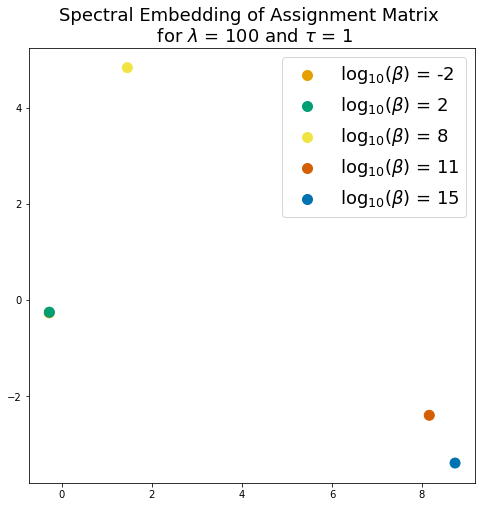

In [25]:
# Visualize Embedding
fig, ax = plt.subplots(figsize = (8,8))


ax.scatter(X_transformed[:,0], X_transformed[:,1], 
           c = beta_colors, 
           s = 100)
for t in cmap_beta.keys():
    ax.scatter([],[], color = cmap_beta[t], label = "$\log_{10}$("+r"$\beta$"+") = {}".format(
        int(np.log10(float(t)))), s = 100)
ax.legend(fontsize = 18)

plt.title("Spectral Embedding of Assignment Matrix \n for "+r"$\lambda$ = 100 and $\tau$ = 1", fontsize = 18)
plt.show()


# Gather Multi-Run Statistics

In [18]:
lam = 1000
tau = 100
beta = 100

num = 50

df_stats = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])

In [19]:
# Get baseline stats.
df_baseline = pd.DataFrame(index = ["Man","Non-Man","White","Non-White"])
for i in range(50):
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    bs_gender = sc.baseline_average_value(category = "gender", in_group = "Man")
    bs_race = sc.baseline_average_value(category = "race", in_group = "White")
    df_baseline[i] = list(bs_gender) + list(bs_race)

mean = [np.around(d,decimals = 3) for d in df_baseline.mean(axis = 1)]
error = [np.around(d,decimals = 3) for d in df_baseline.std(axis = 1)]

df_stats["baseline_mean"] = mean
df_stats["baseline_error"] = error
df_stats

,baseline_mean,baseline_error
Man,12.314,0.130
Non-Man,2.457,0.020
White,13.364,0.136
Non-White,1.589,0.014


In [20]:
df_optimized_2 = pd.DataFrame(index = [i for i in range(num)], columns = ["Man","Non-Man","White","Non-White"])
for i in range(num):
    
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)
    
    assignment_df = sc.learn_optimal_assignment(
                                    hall_df = hall_df, 
                                    art_df = art_df,
                                    cost_df = cost_df,
                                    lam = norm_lam_factor*lam, 
                                    tau=norm_tau_factor*tau, 
                                    init=2,
                                    iterations = 1000) 

    # Get optimized stats.
    os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
    os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
    df_optimized_2.loc[i,:] = list(os_gender) + list(os_race)


mean = [np.around(d,decimals = 3) for d in df_optimized_2.mean(axis = 0)]
error = [np.around(d,decimals = 3) for d in df_optimized_2.std(axis = 0)]

df_stats["init_2_mean"] = mean
df_stats["init_2_error"] = error

In [21]:
df_optimized_3 = pd.DataFrame(index = [i for i in range(num)], columns = ["Man","Non-Man","White","Non-White"])
for i in range(num):
    
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)
    
    assignment_df = sc.learn_optimal_assignment(
                                    hall_df = hall_df, 
                                    art_df = art_df,
                                    cost_df = cost_df,
                                    lam = norm_lam_factor*lam, 
                                    tau=norm_tau_factor*tau, 
                                    init=3,
                                    iterations = 1000) 

    # Get optimized stats.
    os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
    os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
    df_optimized_3.loc[i,:] = list(os_gender) + list(os_race)

mean = [np.around(d,decimals = 3) for d in df_optimized_3.mean(axis = 0)]
error = [np.around(d,decimals = 3) for d in df_optimized_3.std(axis = 0)]

df_stats["init_3_mean"] = mean
df_stats["init_3_error"] = error

In [22]:
df_optimized_4 = pd.DataFrame(index = [i for i in range(num)], columns = ["Man","Non-Man","White","Non-White"])
for i in range(num):
    
    # Fill buildings
    sc.fill_buildings(student_df = student_df, hall_df = hall_df)
    
    # Load data
    hall_df, student_df, art_df = sc.load_data()

    # Get art_capacity_df.
    art_capacity_df = sc.get_art_capacity_with_downsampling(art_df,
                        categories = ["gender","race"])

    # Get building_capacity_df.
    building_capacity_df = sc.get_building_capacity_df()
    building_capacity =  building_capacity_df.values
    art_capacity = art_capacity_df["capacity"].values
    
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                    hall_df = hall_df,
                                    categories = ["gender","race"],
                                    alpha = -1,
                                    beta = beta)
    
    assignment_df = sc.learn_optimal_assignment(
                                    hall_df = hall_df, 
                                    art_df = art_df,
                                    cost_df = cost_df,
                                    lam = norm_lam_factor*lam, 
                                    tau=norm_tau_factor*tau, 
                                    init=4,
                                    iterations = 1000) 

    # Get optimized stats.
    os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
    os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
    df_optimized_4.loc[i,:] = list(os_gender) + list(os_race)

mean = [np.around(d,decimals = 3) for d in df_optimized_4.mean(axis = 0)]
error = [np.around(d,decimals = 3) for d in df_optimized_4.std(axis = 0)]

df_stats["init_4_mean"] = mean
df_stats["init_4_error"] = error

In [23]:
df_stats

,baseline_mean,baseline_error,init_2_mean,init_2_error,init_3_mean,init_3_error,init_4_mean,init_4_error
Man,12.314,0.130,10.538,0.105,10.537,0.099,10.523,0.117
Non-Man,2.457,0.020,4.234,0.038,4.227,0.033,4.236,0.036
White,13.364,0.136,7.183,0.067,7.174,0.094,7.180,0.069
Non-White,1.589,0.014,7.609,0.062,7.606,0.069,7.607,0.053


# Create Grid Search Table

In [24]:
cost_dict = {}
opt_dict = {}
assignment_dict = {}

scaled_lam = [1, 10, 100, 1000, 10000]
scaled_tau = [1, 10, 100, 1000]

betas = [0.01, 100, 10**8, 10**11, 10**15]

In [25]:
for beta in betas:
    cost_df = sc.compute_cost_matrix(art_df = art_df, 
                                        hall_df = hall_df,
                                        categories = ["gender","race"],
                                        alpha = -1,
                                        beta = beta)

    cost_df = cost_df.rename(columns = {art_capacity_df.loc[i,"tuple"]:art_capacity_df.loc[i,"string"] for i in art_capacity_df.index})
    cost_dict[beta] = cost_df

    df_optimized = pd.DataFrame(columns = ["Man","Non-Man","White","Non-White"])
    for lam in scaled_lam:
        for tau in scaled_tau:
            assignment_df = sc.learn_optimal_assignment(
                                    hall_df = hall_df, 
                                    art_df = art_df,
                                    cost_df = cost_df,
                                    lam = norm_lam_factor*lam, 
                                    tau=norm_tau_factor*tau, 
                                    init=2,
                                    iterations = 1000) 

            assignment_dict[f"{beta}_{lam}_{tau}"] = assignment_df.values.reshape(1,-1)

            # Get optimized stats.
            os_gender = sc.optimized_average_value(assignment_df.copy(), category = "gender", in_group = "Man")
            os_race = sc.optimized_average_value(assignment_df.copy(), category = "race", in_group = "White")
            df_optimized.loc[f"{beta}_{lam}_{tau}",:] = list(os_gender) + list(os_race)

    opt_dict[beta] = df_optimized.copy()

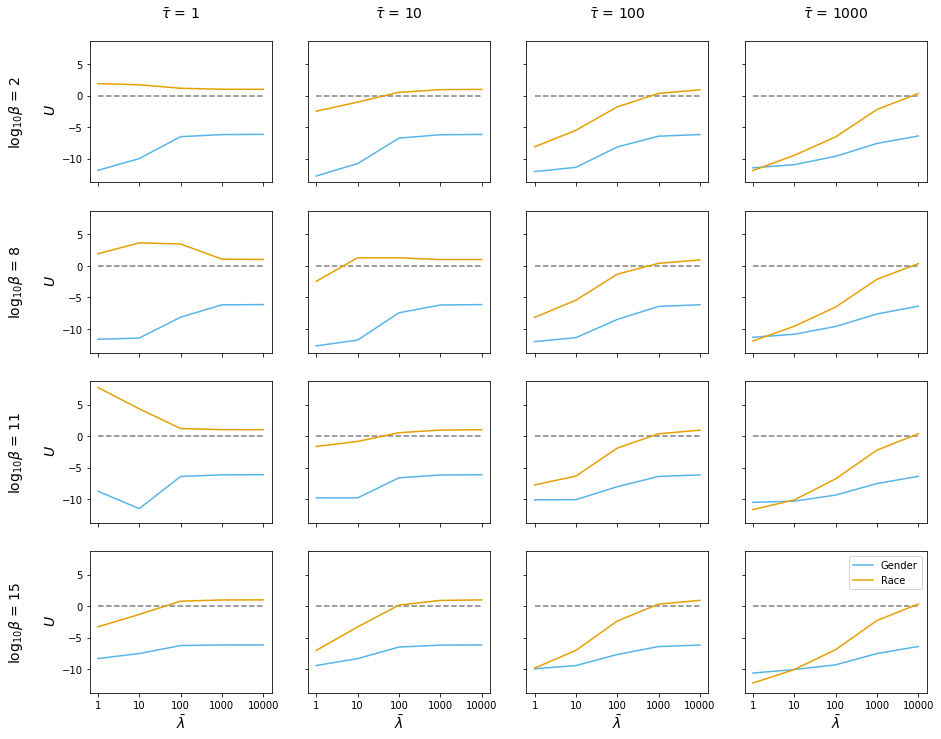

In [26]:
bbetas = [10**2, 10**8, 10**11, 10**15]

cmap = {"Man":COLOR_MAP["light_blue"],
       "Non-Man":COLOR_MAP["dark_blue"],
       "White":COLOR_MAP["light_orange"],
       "Non-White":COLOR_MAP["dark_orange"]}
lmap = {"Man":"--",
       "Non-Man":"-",
       "White":"--",
       "Non-White":"-"}

fig, ax = plt.subplots(len(bbetas),4,figsize = (15,12), sharex = True, sharey = True)

for i in range(len(bbetas)):
    beta = bbetas[i]
    df_optimized = opt_dict[beta]
    for j in range(len(scaled_tau)):
        tau = scaled_tau[j]
        tau_idx = [d for d in df_optimized.index if float(d.split("_")[2]) == tau]
        #for c in df_optimized.columns:
        x = df_optimized.loc[tau_idx,"Non-Man"].values - df_optimized.loc[tau_idx,"Man"].values
        ax[i,j].plot(x, color = cmap["Man"], label = "Gender")
        
        x = df_optimized.loc[tau_idx,"Non-White"].values - df_optimized.loc[tau_idx,"White"].values
        ax[i,j].plot(x, color = cmap["White"], label = "Race")
        ax[i, j].set_xticks([i for i in range(len(scaled_lam))])
        ax[i, j].set_xticklabels(scaled_lam)
        ax[i,j].plot(pd.Series(0, index = tau_idx).values, zorder = 0, 
                     linestyle = "--", 
                     color = "grey")

ax[i, j].legend()
for i in range(len(bbetas)):
    ax[i,0].set_ylabel(r"log$_{10}\beta$"+f" = {int(np.log10(bbetas[i]))}\n \n"+r" $U$", fontsize = 14)
for j in range(len(scaled_tau)):
    ax[0, j].set_title(r"$\bar{\tau}$"+f" = {scaled_tau[j]}\n", fontsize = 14)
    ax[-1, j].set_xlabel(r'$\bar{\lambda}$', fontsize = 14)
    
plt.show()